In [1]:
import os
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import shutil
import pyrouge
import logging
from collections import Counter, defaultdict


REF_FOLDER = '../cloud_data/baseline/decode_test_400maxenc_4beam_35mindec_100maxdec_ckpt-55092/reference/'
URL_LIST_FILE = '../prepare_data/cnn-dailymail/url_lists/small_test.txt'
CNN_STORY_DIR = '/Users/j.zhou/mlp_project/prepare_data/cnn-dailymail/cnn_stories_tokenized/'
DM_STORY_DIR = '/Users/j.zhou/mlp_project/prepare_data/cnn-dailymail/dm_stories_tokenized/'

CNN_STORY_HASH = set(os.listdir('../prepare_data/cnn/stories/'))
DM_STORY_HASH = set(os.listdir('../prepare_data/dailymail/stories/'))

VOCAB_PATH = '../data/finished_files/vocab'

with open(URL_LIST_FILE, 'r') as f:
    URL_LIST = f.readlines()

In [2]:
def get_ref(id_):
    ref_folder = REF_FOLDER
    ref_path = os.path.join(ref_folder, '{:06d}_reference.txt'.format(id_))
    ret = []
    with open(ref_path, 'r') as f:
        for line in f:
            words = line.strip().split()
            ret.extend(words)
    return ret


def get_sum(id_, model):
    model_path = os.path.join('../cloud_data/', model)
    file_paths = os.listdir(model_path)
    file_path = [path for path in file_paths if 'decode_test_400maxenc' in path][0]
    decode_file_path = os.path.join(model_path, file_path, 'decoded', '{:06d}_decoded.txt'.format(id_))
    ret = []
    with open(decode_file_path, 'r') as f:
        for line in f:
            ret.extend(line.strip().split())
    return ret

In [30]:
URL_LIST[4743]

'http://web.archive.org/web/20150724170514id_/http://www.dailymail.co.uk/sciencetech/article-3038219/How-global-warming-HELPED-man-Earliest-humans-migrated-Europe-1-4-million-years-ago-thanks-rising-temperatures.html\n'

In [3]:
def compare_ref_decode(line_id, models):
    ref = ' '.join(get_ref(line_id))
    print('line_id %d: REF ' % line_id)
    print(ref)
    for model in models:
        decode = ' '.join(get_sum(line_id, model))
        print('=' * 15)
        print('model %s ' % model)
        print(decode)

def get_full_article(line_id):
    url = URL_LIST[line_id][:-1]
    def hashhex(s):
        """Returns a heximal formated SHA1 hash of the input string."""
        h = hashlib.sha1()
        h.update(s.encode())
        return h.hexdigest()
    story_filename = hashhex(url) + '.story'
    if story_filename in CNN_STORY_HASH:
        story_filename = os.path.join(CNN_STORY_DIR, story_filename)
    elif story_filename in DM_STORY_HASH:
        story_filename = os.path.join(DM_STORY_DIR, story_filename)
    else:
        raise ValueError
    ret = []
    with open(story_filename, 'r') as f:
        for line in f:
            words = line.strip().split()
            ret.extend([w.lower() for w in words])
    return ret

In [4]:
def build_vocab_freq():
    cnt = Counter()
    n = 0
    with open(VOCAB_PATH, 'r') as f:
        for line in f:
            w, freq = line.strip().split(' ')
            cnt[w] = int(freq)
            n += 1
    return cnt

freq = build_vocab_freq()

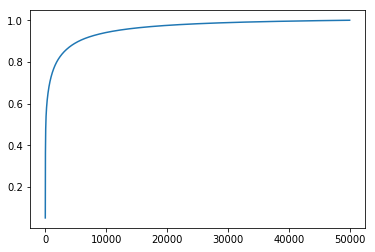

In [5]:
x = [tp[1] for tp in freq.most_common()[:50000]]
arr = np.cumsum(x)
plt.plot(range(len(x)), arr / arr[-1])
plt.show()

In [6]:
ratio = arr / arr[-1]
ratio[20000]

0.975339353121123

# EVAL rouge on subset

In [7]:
def rouge_eval(ref_dir, dec_dir):
    """Evaluate the files in ref_dir and dec_dir with pyrouge, returning results_dict"""
    r = pyrouge.Rouge155()
    r.model_filename_pattern = '#ID#_reference.txt'
    r.system_filename_pattern = '(\d+)_decoded.txt'
    r.model_dir = ref_dir
    r.system_dir = dec_dir
    logging.getLogger('global').setLevel(
        logging.WARNING)  # silence pyrouge logging
    rouge_results = r.convert_and_evaluate()
    return r.output_to_dict(rouge_results)

def eval_rouge_on_subset(ids, models):
    ret = {}
    for model in models:
        if os.path.exists('./tmp'):
            shutil.rmtree('tmp')
        os.mkdir('tmp')
        os.mkdir('tmp/dec')
        os.mkdir('tmp/ref')

        for new_i, i in enumerate(ids):
            src_ref = os.path.join(REF_FOLDER, '{:06d}_reference.txt'.format(i))

            model_path = os.path.join('../cloud_data/', model)
            file_paths = os.listdir(model_path)
            file_path = [path for path in file_paths if 'decode_test_400maxenc' in path][0]
            src_dec = os.path.join(model_path, file_path, 'decoded', '{:06d}_decoded.txt'.format(i))

            shutil.copyfile(src_ref, 'tmp/ref/{:06d}_reference.txt'.format(i))
            shutil.copyfile(src_dec, 'tmp/dec/{:06d}_decoded.txt'.format(i))
            
        ret[model] = rouge_eval('/Users/j.zhou/mlp_project/notebooks/tmp/ref',
                         '/Users/j.zhou/mlp_project/notebooks/tmp/dec')

        shutil.rmtree('tmp')
        
    return ret

# Filter Rare Words
let's define word after 40000 as rare words, words ranked after 50000 are UNK

In [8]:
# unks = set(tp[0] for tp in freq.most_common()[50000:])
freq_words = set(tp[0] for tp in freq.most_common()[:40000])

def extract_articles(words):
    ids, id_word_map = set(), defaultdict(set)
    for i in range(5000):
        article = set(get_full_article(i))
        for w in article:
            if w not in words:
                ids.add(i)
                id_word_map[i].add(w)
    return ids, id_word_map

ids, id_word_map = extract_articles(freq_words)

In [19]:
new_ids = []
for id_ in id_word_map:
    if len(id_word_map[id_]) >= 20:
        new_ids.append(id_)

In [20]:
len(new_ids)

772

In [21]:
rouge_scores_baseline = eval_rouge_on_subset(new_ids, ['baseline', 'baseline_coverage'])
rouge_scores_char_cat = eval_rouge_on_subset(new_ids, ['char_concate', 'char_concate_coverage'])
rouge_scores_char_enc = eval_rouge_on_subset(new_ids, ['char_encoder', 'char_encoder_coverage'])

In [22]:
rouge_scores_baseline['baseline']['rouge_1_f_score']

0.32261

In [23]:
rouge_scores_baseline['baseline_coverage']['rouge_1_f_score']

0.33268

In [24]:
rouge_scores_char_cat['char_concate_coverage']['rouge_1_f_score']

0.33018

In [25]:
rouge_scores_char_cat['char_concate']['rouge_1_f_score']

0.33102

In [26]:
rouge_scores_char_enc['char_encoder_coverage']['rouge_1_f_score']

0.3275

In [27]:
rouge_scores_char_enc['char_encoder']['rouge_1_f_score']

0.33289

In [9]:
def extract_summary_with_rare_words(models, id_word_map):
    ret = defaultdict(list)
    for id_ in id_word_map:
        for model in models:
            dec = set(get_sum(id_, model))
            for word in id_word_map[id_]:
                if word in dec:
                    ret[(id_, word)].append(model)
    return ret

ret = extract_summary_with_rare_words(['baseline', 'char_encoder', 'char_concate'], new_id_word_map)

NameError: name 'new_id_word_map' is not defined

In [29]:
compare_ref_decode(4743, ['baseline', 'char_concate', 'char_encoder'])

line_id 4743: REF 
spanish researchers say climate change impacted human migration . until 1.4 million years ago it was too cold to inhabit southeast spain . but then the climate warmed to 13 °c -lrb- 55 °f -rrb- and became more humid . this enabled hominins - our distant ancestors - to move to new regions .
model baseline 
researchers believe the spread of our distant human ancestors had been halted by colder and drier temperatures . but as conditions warmed , they were able to branch out from africa into spain , and ultimately spread across europe .
model char_concate 
researchers believe that the spread of our distant human ancestors , the hominins , had been halted by colder and drier temperatures . but as conditions warmed , they were able to branch out from africa into spain , and ultimately spread across europe .
model char_encoder 
researchers believe the spread of our distant human ancestors , the hominins , had been halted by colder and drier temperatures . but as conditions 

# POS can handle name

In [ ]:
print(get_full_article(456))

In [ ]:
compare_ref_decode(456, ['baseline', 'baseline_coverage', 'char_concate', 'char_concate_coverage', 'pos_concate', 'pos_concate_coverage'])

In [ ]:
import sys
sys.path.append('../pointer-generator/pos_tagger/')
from pos_tagging import get_POS_tagged_sent

In [ ]:
get_POS_tagged_sent('Model and environmental scientist Laura Wells uses figure to flaunt ocean inspired swimwear .'.split())

In [ ]:
compare_ref_decode(4777, ['baseline', 'pos_encoder', 'char_concate'])

In [ ]:
article = get_full_article(4978)

# How abstractive

In [ ]:
def who_create_new_word(models, line_ids=None):
    if line_ids is None:
        line_ids = range(5000)
    
    ret = defaultdict(dict)
    for line_id in line_ids:
        art = set(get_full_article(line_id))
        for model in models:
            model_words = set(get_sum(line_id, model))
            diff = model_words - art
            if len(diff) > 0:
                ret[line_id][model] = diff
    return ret

In [ ]:
res = who_create_new_word(['baseline', 'char_concate', 'char_encoder', 'char_pos_concate', 'char_pos_encoder'])

In [ ]:
res